# NLP Emotion Classification From Text

**This project is based on Machine Learning and Natural Language Processing (NLP) techniques and focuses on emotion classification. The dataset consists of sentences labeled with different emotions (e.g., joy, anger, sadness). The goal is to build machine learning models that can automatically classify emotions from raw text.**

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import nltk

## 2. Load & Preprocess

In [2]:
df = pd.read_csv("train.txt", sep=";", header=None, names=["text", "emotion"])

unique_emotion = {emo: i for i, emo in enumerate(df["emotion"].unique())}
emotion_numbers = {i: emo for emo, i in unique_emotion.items()}
df["label"] = df["emotion"].map(unique_emotion)


In [3]:
df.head(3)

,text,emotion,label
0,i didnt feel humiliated,sadness,0
1,i can go from feeling so hopeless to so damned...,sadness,0
2,im grabbing a minute to post i feel greedy wrong,anger,1


In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

def remove_punc(txt):
    return txt.translate(str.maketrans('', '', string.punctuation))

def remove_numbers(txt):
    return ''.join([i for i in txt if not i.isdigit()])

def remove_emojis(txt):
    return ''.join([i for i in txt if i.isascii()])

nltk.download("stopwords", quiet=True)
stop_words = set(stopwords.words('english'))

def remove_stopwords(txt):
    return ' '.join([w for w in txt.split() if w not in stop_words])

df["clean_text"] = (df["text"].astype(str).str.lower()
                    .apply(remove_punc)
                    .apply(remove_numbers)
                    .apply(remove_emojis)
                    .apply(remove_stopwords))


In [5]:
df

,text,emotion,label,clean_text
0,i didnt feel humiliated,sadness,0,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,0,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,anger,1,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,2,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,anger,1,feeling grouchy
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,0,brief time beanbag said anna feel like beaten
15996,i am now turning and i feel pathetic that i am...,sadness,0,turning feel pathetic still waiting tables sub...
15997,i feel strong and good overall,joy,5,feel strong good overall
15998,i feel like this was such a rude comment and i...,anger,1,feel like rude comment im glad


## 3. Split & Vectorize

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"])

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

bow = CountVectorizer()
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

## 4. Train Models & Compare

In [13]:
results = []

# Naive Bayes (BoW)

nb_bow = MultinomialNB().fit(X_train_bow, y_train)
pred_nb_bow = nb_bow.predict(X_test_bow)
acc_nb_bow = accuracy_score(y_test, pred_nb_bow)
results.append(("Naive Bayes", "BoW", acc_nb_bow, pred_nb_bow))

# Naive Bayes (TF-IDF)

nb_tfidf = MultinomialNB().fit(X_train_tfidf, y_train)
pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)
acc_nb_tfidf = accuracy_score(y_test, pred_nb_tfidf)
results.append(("Naive Bayes", "TF-IDF", acc_nb_tfidf, pred_nb_tfidf))

# Logistic Regression (TF-IDF)

lr = LogisticRegression(max_iter=1000).fit(X_train_tfidf, y_train)
pred_lr = lr.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, pred_lr)
results.append(("Logistic Regression", "TF-IDF", acc_lr, pred_lr))

# Linear SVM (TF-IDF)

svm = LinearSVC().fit(X_train_tfidf, y_train)
pred_svm = svm.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, pred_svm)
results.append(("Linear SVM", "TF-IDF", acc_svm, pred_svm))

# XGBoost 

xgb_clf = XGBClassifier(
        objective="multi:softmax",
        num_class=len(set(y_train)),
        eval_metric="mlogloss",
        n_estimators=200,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        learning_rate=0.1,
        n_jobs=2,
        tree_method="hist"
    ).fit(X_train_tfidf, y_train)
pred_xgb = xgb_clf.predict(X_test_tfidf)
acc_xgb = accuracy_score(y_test, pred_xgb)
results.append(("XGBoost", "TF-IDF", acc_xgb, pred_xgb))


results_df = pd.DataFrame(results, columns=["Model","Features","Accuracy","Predictions"]).sort_values("Accuracy", ascending=False)
print(results_df[["Model","Features","Accuracy"]])
best_model_name, best_features, best_acc, best_preds = results_df.iloc[0]


                 Model Features  Accuracy
3           Linear SVM   TF-IDF  0.887500
4              XGBoost   TF-IDF  0.879062
2  Logistic Regression   TF-IDF  0.850625
0          Naive Bayes      BoW  0.767500
1          Naive Bayes   TF-IDF  0.662188


In [14]:
results_df.iloc[0]

Model                                                 Linear SVM
Features                                                  TF-IDF
Accuracy                                                  0.8875
Predictions    [5, 0, 0, 4, 5, 0, 1, 0, 1, 1, 1, 0, 5, 0, 0, ...
Name: 3, dtype: object

## 5. Confusion Matrix & Classification Report

Classification Report (best model):
              precision    recall  f1-score   support

     sadness       0.92      0.93      0.92       933
       anger       0.87      0.84      0.86       432
        love       0.85      0.72      0.78       261
    surprise       0.84      0.74      0.79       115
        fear       0.89      0.84      0.86       387
         joy       0.88      0.95      0.91      1072

    accuracy                           0.89      3200
   macro avg       0.88      0.83      0.85      3200
weighted avg       0.89      0.89      0.89      3200



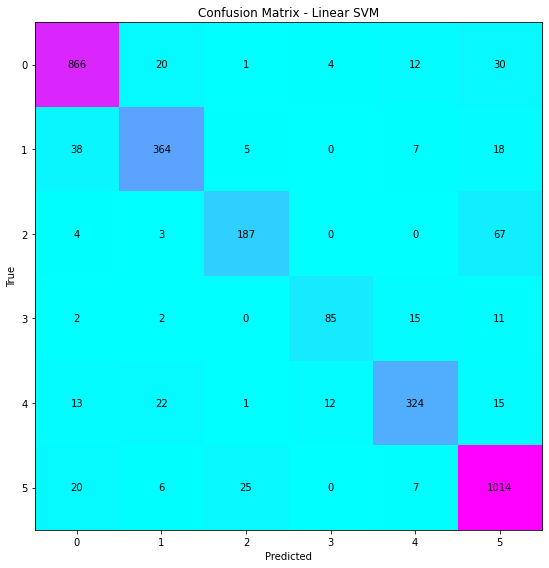

In [9]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, best_preds)
print("Classification Report (best model):")
print(classification_report(y_test, best_preds, target_names=[emotion_numbers[i] for i in sorted(emotion_numbers.keys())]))

plt.figure(figsize=(10,8))
plt.imshow(cm,cmap='cool')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.tight_layout()
plt.show()


## 6. Visualization: Emotion Distribution 

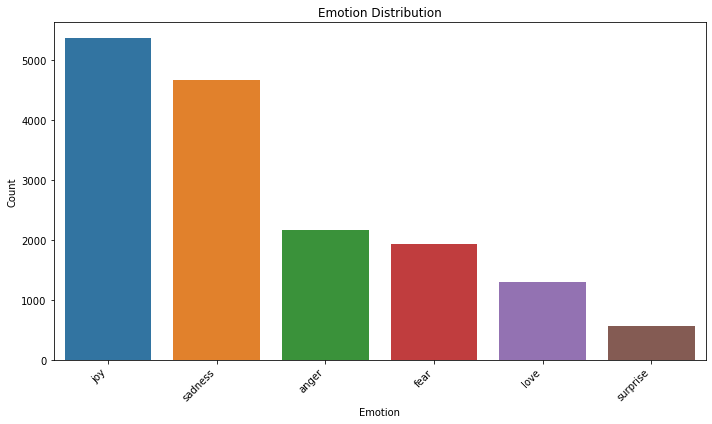

In [10]:
counts = df["emotion"].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 7. Hyperparameter Tuning (GridSearchCV)

In [11]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression tuning
lr_params = {"C":[0.1,1.0,3.0], "penalty":["l2"], "solver":["lbfgs","liblinear"]}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3, n_jobs=-1).fit(X_train_tfidf, y_train)
best_lr = lr_grid.best_estimator_
best_lr_acc = accuracy_score(y_test, best_lr.predict(X_test_tfidf))
print("Best LR params:", lr_grid.best_params_, " | Accuracy:", best_lr_acc)

# Naive Bayes tuning
nb_params = {"alpha":[0.1,0.5,1.0]}
nb_grid = GridSearchCV(MultinomialNB(), nb_params, cv=3, n_jobs=-1).fit(X_train_tfidf, y_train)
best_nb = nb_grid.best_estimator_
best_nb_acc = accuracy_score(y_test, best_nb.predict(X_test_tfidf))
print("Best NB params:", nb_grid.best_params_, " | Accuracy:", best_nb_acc)


Best LR params: {'C': 3.0, 'penalty': 'l2', 'solver': 'liblinear'}  | Accuracy: 0.873125
Best NB params: {'alpha': 0.1}  | Accuracy: 0.745625


## 8. Error Analysis

In [12]:
# pick best overall among earlier best and tuned ones

candidates = [(best_model_name, best_acc, best_preds)]
candidates.append(("Logistic Regression (Tuned)", best_lr_acc, best_lr.predict(X_test_tfidf)))
candidates.append(("Naive Bayes (Tuned)", best_nb_acc, best_nb.predict(X_test_tfidf)))
overall_best = max(candidates, key=lambda x: x[1])
overall_name, overall_acc, overall_pred = overall_best

test_df = pd.DataFrame({"text": X_test.values, "true": y_test.values, "pred": overall_pred})
test_df["true_label"] = test_df["true"].map(emotion_numbers)
test_df["pred_label"] = test_df["pred"].map(emotion_numbers)
mis_df = test_df[test_df["true"] != test_df["pred"]].copy()
print(f"Overall best: {overall_name} | Accuracy: {overall_acc:.4f}")
print("Sample misclassifications:")
mis_df.head(10)


Overall best: Linear SVM | Accuracy: 0.8875
Sample misclassifications:


,text,true,pred,true_label,pred_label
7,girlfriend sent letter shiny picture,5,0,joy,sadness
23,feelings seriously feel love someone treats di...,5,2,joy,love
35,eyes questionable whether shes feeling graciou...,2,5,love,joy
43,hate im refered game guitar hero mean cool got...,1,5,anger,joy
47,feel like shouldnt bother people petty stupid ...,1,0,anger,sadness
48,barely even feel like explaining weird history...,3,5,surprise,joy
60,hate seeing red windows even feel inside reson...,1,0,anger,sadness
63,feel blessed given chance love,2,5,love,joy
67,know feelings stem part accepted mainstream im...,5,2,joy,love
70,watched thanksgiving morning feeling doubly bl...,2,5,love,joy


**THANK YOU**